# 0. Config
- Board model: `board[c] = r` if queen

<img src="./img/5.jpg" width="600"/>

- Cost function: each violation of the rule +1 cost

<img src="./img/6.jpg"  width="600"/>


# 1. Hill Climbing
- Algo
    - Start with a config
    - Search for all possible next moves -> Only choose the move with lower cost than the current
        + Loop through all col
        + Try moving Q to a new row -> evaluate new cost
- Cost always go down
- Prone to local optima

<img src="./img/7.jpg" width="600"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt


class N_Queen_HC(object):
    def __init__(self):
        self._N = None
        self._board = None

        self._J = None

    def __print_ans(self):
        for r in range(self._N):
            for c in range(self._N):
                end_c = '\n' if c == self._N - 1 else ' '
                print(1, end=end_c) if r == self._board[c] \
                    else print(0, end=end_c)

    def __plot_cost(self):
        x = np.arange(len(self._J))
        with plt.style.context(['science', 'notebook', 'grid']):
            plt.figure(figsize=(10,5))

            plt.plot(
                x, self._J,
                linewidth=1.5)
            plt.plot(
                x, self._J, 
                'rx', markersize=3)

            plt.grid(True)
            plt.axis('tight')

            plt.xlabel('Iter', fontsize=18)
            plt.ylabel('Cost', fontsize=20)
            plt.title ('Hill Climbing')
            plt.show()

    def __f_cost(self, board):
        cost = 0
        for c1 in range(self._N-1):
            for c2 in range(c1+1, self._N):
                # if same row (r1 == r2)
                if board[c1] == board[c2]:
                    cost += 1

                # if same / diag (r1 + c1 == r2 + c2)
                #    or \ diag (r1 - c1 + N-1 == r1 - c1 + N-1) 
                if board[c1] + c1 == board[c2] + c2 \
                        or board[c1] - c1 == board[c2] - c2:
                    cost += 1
        return cost

    def fit(self, n_iters=1000):
        # Init board, all Q in the same row
        #     {1,1,1,1},
        #     {0,0,0,0},
        #     {0,0,0,0},
        #     {0,0,0,0},
        self._board = [0] * self._N

        # cost history for plotting
        cur_cost = self.__f_cost(self._board) 
        self._J = [cur_cost]

        # Fitting
        for i in range(n_iters):
            # Cache next move
            nex_moves = []

            # Search all possible next moves -> find all lower cost possible
            for c in range(self._N):
                for r in range(self._N):

                    # Skip current config
                    if self._board[c] == r:
                        continue

                    # Pick 1 queen -> move to new r,c to evaluate
                    board_copy = self._board[:]
                    board_copy[c] = r
                    new_cost = self.__f_cost(board_copy)

                    # Only accept lower(or equal) cost config
                    if new_cost <= cur_cost:
                        nex_moves.append( (r, c, new_cost) )

            # Randomly pick the next move
            dice = np.random.randint(len(nex_moves))
            r_, c_, new_cost_ = nex_moves[dice]

            # Update
            self._board[c_] = r_
            cur_cost = new_cost_
            self._J.append(cur_cost)

            # Early stopping
            if cur_cost == 0:
                print('Optimal Solution found:')
                break

        # Return ans + plot
        self.__print_ans()
        self.__plot_cost()


    def solve(self, N=4, n_iters=int(1e6)):
        self._N = N
        self.fit(n_iters=n_iters)

Optimal Solution found:
0 0 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1
0 0 0 0 0 0 1 0 0 0
0 0 0 0 1 0 0 0 0 0
1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 1 0
0 0 0 0 0 1 0 0 0 0
0 0 0 0 0 0 0 1 0 0
0 1 0 0 0 0 0 0 0 0
0 0 0 1 0 0 0 0 0 0


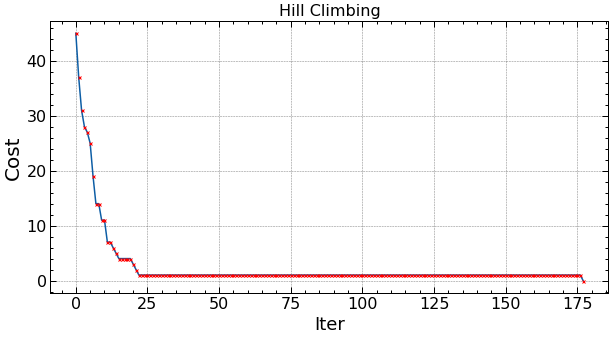

In [2]:
hc = N_Queen_HC()
hc.solve(N=10, n_iters=int(1e6))

# 2. Simulated Annealing
- Algo
    + Random the next move (not exam all)
    + If next stage better -> move
    + If not consider moving to with a probability

- Probability of acceptance p
    - $p = min(1,e^{\frac{\Delta E}{T}})$
        + $\Delta E = cur\_cost - new\_cost$, $(\Delta E < 0)$ 
        + T = temperature

- An exmaple of T function: $T(t+1) = max(T(t)*\alpha, 0.01)$
    + $T$: **high** = likely accept the new candidate, **low** = likely reject
    + $\alpha$: decay rate for T, **high** = T cooldown slower
        + Example: $\alpha$ = 0.95
 
- Balance Explore - Exploit
    + At first, gives non improving moves a chance to be picked
    + Gradually turns into Hill Climbing, only accepting improving moves
    - Cost can go up to escape local optima

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random


class N_Queen_SA(object):
    def __init__(self):
        self._N = None
        self._board = None

        self._J = None

    def __print_ans(self):
        for r in range(self._N):
            for c in range(self._N):
                end_c = '\n' if c == self._N - 1 else ' '
                print(1, end=end_c) if r == self._board[c] \
                    else print(0, end=end_c)

    def __plot_cost(self):
        x = np.arange(len(self._J))
        with plt.style.context(['science', 'notebook', 'grid']):
            plt.figure(figsize=(10,5))
            plt.plot(
                x, self._J,
                linewidth=1.5)
            plt.plot(
                x, self._J, 
                'rx', markersize=3)

            plt.grid(True)
            plt.axis('tight')

            plt.xlabel('Iter', fontsize=18)
            plt.ylabel('Cost', fontsize=20)
            plt.title ('Simulated Annealing')
            plt.show()

    def __f_cost(self, board):
        cost = 0
        for c1 in range(self._N-1):
            for c2 in range(c1+1, self._N):
                # if same row (r1 == r2)
                if board[c1] == board[c2]:
                    cost += 1

                # if same / diag (r1 + c1 == r2 + c2)
                #    or \ diag (r1 - c1 + N-1 == r1 - c1 + N-1) 
                if board[c1] + c1 == board[c2] + c2 \
                        or board[c1] - c1 == board[c2] - c2:
                    cost += 1
        return cost

    def fit(self, n_iters=1000):
        # Init board, all Q in the same row
        #     {1,1,1,1},
        #     {0,0,0,0},
        #     {0,0,0,0},
        #     {0,0,0,0},
        self._board = [0] * self._N

        # cost history for plotting
        cur_cost = self.__f_cost(self._board) 
        self._J = [cur_cost]

        # Init params
        T = self._N**2
        alpha = 0.95

        # Fitting
        for i in range(n_iters):
            accept = False

            # Pick the the next stage
            r_, c_ = None, None
            new_cost_ = None
            while not accept:           
                r_ = np.random.randint(self._N)
                c_ = np.random.randint(self._N)

                # Skip current config
                if self._board[c_] == r_:
                    continue

                # Pick 1 queen -> move to new r,c to evaluate
                board_copy = self._board[:]
                board_copy[c_] = r_
                new_cost_ = self.__f_cost(board_copy)

                # if new_cost is better -> accept this stage
                if new_cost_ < cur_cost:
                    accept = True

                # If new_cost is not better -> setup a probability to accept this stage
                else:
                    delta_E = cur_cost - new_cost_
                    prob =  min(1.0, np.exp(delta_E / T))
                    accept = random.choices([True, False], weights=[prob, 1-prob])[0]

            # Update
            self._board[c_] = r_
            cur_cost = new_cost_
            self._J.append(cur_cost)

            # Update Temp
            T = max(T*alpha, 0.01)

            # Early stopping
            if cur_cost == 0:
                print('Optimal Solution found:')
                break

        # Return ans + plot
        self.__print_ans()
        self.__plot_cost()

    def solve(self, N=4, n_iters=int(1e6)):
        self._N = N
        self.fit(n_iters=n_iters)

Optimal Solution found:
0 0 1 0 0 0 0 0 0 0
0 0 0 0 0 0 1 0 0 0
0 0 0 0 0 0 0 0 1 0
0 0 0 1 0 0 0 0 0 0
0 0 0 0 0 1 0 0 0 0
1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1
0 1 0 0 0 0 0 0 0 0
0 0 0 0 1 0 0 0 0 0
0 0 0 0 0 0 0 1 0 0


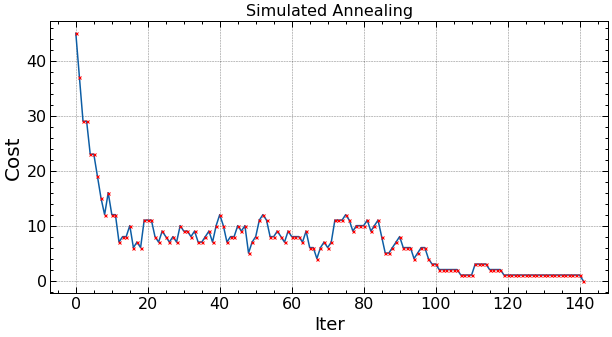

In [4]:
hc = N_Queen_SA()
hc.solve(N=10, n_iters=int(1e6))